In [1]:
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon
import os
import yaml
from pathlib import Path
import glob
import sys
base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent.parent

# Bare soil samples: location

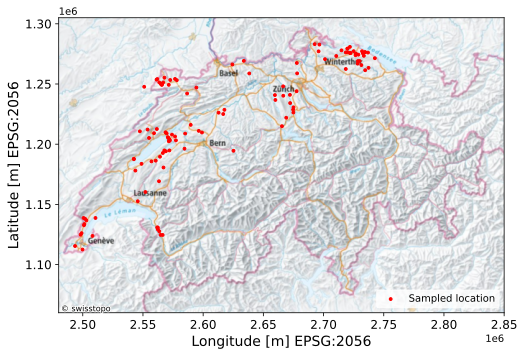

In [5]:
tiles = ['32TMT', '32TLT', '32TNT', '31TGM', '31TGN']

pixs_df = [pd.read_pickle(file) for tile_id in tiles for file in glob.glob(str(base_dir.joinpath(f'results/GEE_baresoil_v2/sampled_pixels_{tile_id}.pkl')))]
pixs_df = pd.concat(pixs_df, ignore_index=True)
pixs_gdf= gpd.GeoDataFrame(pixs_df, geometry=pixs_df.geometry, crs='EPSG:2056')

fig, ax = plt.subplots(figsize=(8,6))
pixs_gdf.plot(ax=ax, color='r', markersize=8, label='Sampled location')
# Set to extent of switzerland
minx, miny, maxx, maxy = [2480000, 1060000, 2850000, 1305000]
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
cx.add_basemap(ax, crs=pixs_gdf.crs, source=cx.providers.SwissFederalGeoportal.NationalMapColor) #
ax.set_xlabel('Longitude [m] EPSG:2056', fontsize=14)
ax.set_ylabel('Latitude [m] EPSG:2056', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
#ax.set_xticklabels(ax.get_xticks(), fontsize=14)
#ax.set_yticklabels(ax.get_yticks(), fontsize=14)
#ax.set_title('Sampled bare soil spectra', fontsize=16)
# Add legend
legend = ax.legend(loc='lower right')
legend.get_frame().set_edgecolor('white')  # Set legend border color
legend.get_frame().set_facecolor('white')  # Set legend fill color
plt.savefig('manuscript_figures/bare_soil_location_swissmap_legend.png')

# Bare soil samples: spectra
- compare spectra
- compare years?

In [114]:
spectra = pd.read_pickle(base_dir.joinpath('results/GEE_baresoil_v2/sampled_spectra_all_CH.pkl'))

In [115]:
from matplotlib import style 
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


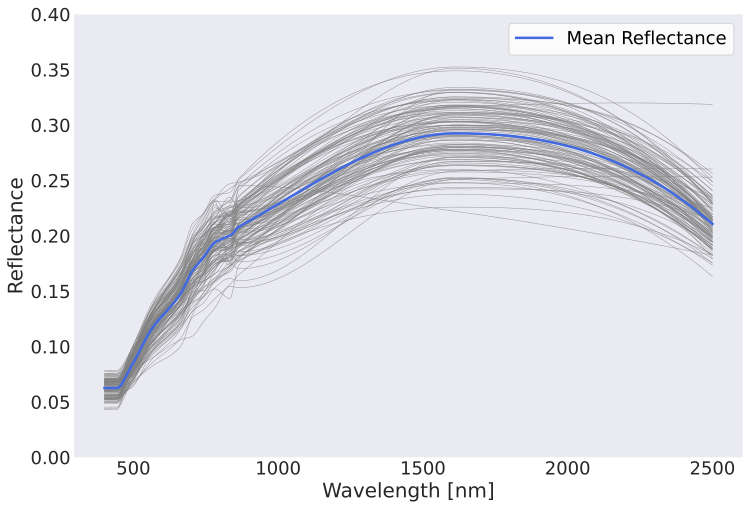

In [147]:
fig, ax = plt.subplots(figsize=(12,8))

plt.style.use('default')

spectra.T.plot(ax=ax, legend=False, color='grey', linewidth=0.5, alpha=0.8)

# Plot the mean line in bold
mean_spectra = spectra.mean(axis=0)
mean_spectra_df = mean_spectra.reset_index().rename(columns={0: 'Reflectance'})
mean_spectra_df.columns = ['nm', 'Reflectance']
mean_spectra_df.plot(ax=ax, x='nm', y='Reflectance', color='royalblue', linewidth=2.5, label='Mean Reflectance')

plt.ylim((0,0.4))
plt.ylabel('Reflectance', fontsize=20)
plt.xlabel('Wavelength [nm]', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=[handles[-1]], labels=[labels[-1]], loc='upper right', fontsize=18)
plt.savefig('manuscript_figures/bare_soil_spectra_allgrey.png')
plt.show()

# Addition of noise to spectra
- Effect of inverse 1 % on data

In [128]:
# Open ray data

data_path = ['../../results/lut_based_inversion/soil_scaled/prosail_danner-etal_switzerland_S2A_lai-cab-ccc-car_lut_no-constraints.pkl', \
    '../../results/lut_based_inversion/soil_scaled/prosail_danner-etal_switzerland_S2B_lai-cab-ccc-car_lut_no-constraints.pkl']

if isinstance(data_path, str):
  df = pd.read_pickle(data_path)
elif isinstance(data_path, list):
  dfs = [pd.read_pickle(path) for path in data_path]
  df = pd.concat(dfs, axis=0, ignore_index=True)


# Open noisy data

noisy_path = '../../results/lut_based_inversion/soil_scaled/prosail_danner-etal_switzerland_lai-cab-ccc-car_lut_no-constraints_inverse1.pkl'
df_noise = pd.read_pickle(noisy_path)

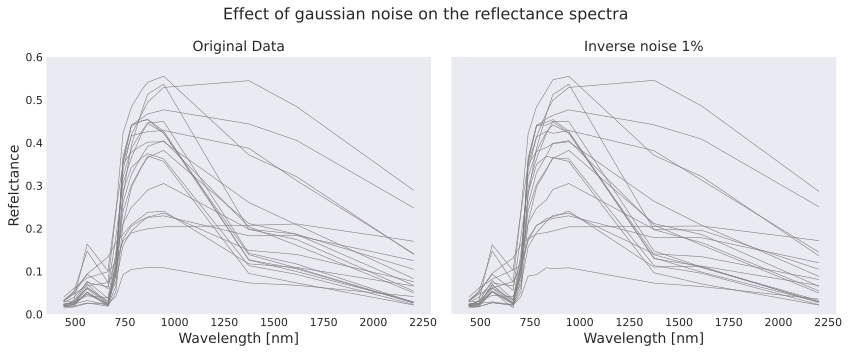

In [149]:
cols = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']
x = [442.7, 492.4, 559.8, 664.6, 704.1, 740.5, 782.8, 832.8, 864.7, 945.1, 1373.5, 1613.7, 2202.4]
n = 20

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharey=True)
axs = axs.flatten()

df_sample = df.sample(n, random_state=42)
axs[0].set_title('Original Data', fontsize=14) 
axs[0].plot(x, df_sample[cols].T, linestyle='-', color='grey', linewidth=0.6)
axs[0].set_ylim(0, 0.6) 
axs[0].set_xlabel('Wavelength [nm]', fontsize=14) 
axs[0].set_ylabel('Refelctance', fontsize=14) 

df_noise_sample = df_noise.sample(n, random_state=42)
axs[1].set_title(f'Inverse noise 1%', fontsize=14) 
axs[1].plot(x, df_noise_sample[cols].T, linestyle='-', color='grey', linewidth=0.6)
axs[1].set_xlabel('Wavelength [nm]', fontsize=14) 


plt.suptitle(f'Effect of gaussian noise on the reflectance spectra', fontsize=16)
plt.tight_layout()

Text(0.5, 1.0, 'Addition of noise to spectra')

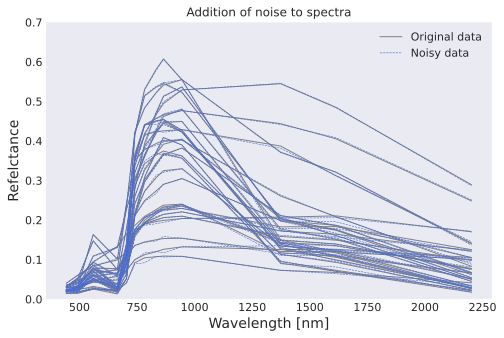

In [164]:
cols = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']
x = [442.7, 492.4, 559.8, 664.6, 704.1, 740.5, 782.8, 832.8, 864.7, 945.1, 1373.5, 1613.7, 2202.4]
n = 30

fig, axs = plt.subplots(figsize=(8, 5))

df_sample = df.sample(n, random_state=42)
df_noise_sample = df_noise.sample(n, random_state=42)

axs.plot(x, df_sample[cols].T, linestyle='-', color='grey', linewidth=1, label='Original data')
axs.plot(x, df_noise_sample[cols].T, linestyle='--', color='royalblue', linewidth=0.6, label='Noisy data')

# Creating custom legend
original_line = plt.Line2D([], [], color='grey', linestyle='-', linewidth=1, label='Original data')
noisy_line = plt.Line2D([], [], color='royalblue', linestyle='--', linewidth=0.6, label='Noisy data')
axs.legend(handles=[original_line, noisy_line])

axs.set_ylim(0, 0.7) 
axs.set_xlabel('Wavelength [nm]', fontsize=14) 
axs.set_ylabel('Refelctance', fontsize=14) 
axs.set_title('Addition of noise to spectra')
#axs.legend()

# Effect of noise on model scores

In [23]:
noise_results = '../../results/noise_results_NN_noisev2.xlsx'
df = pd.read_excel(noise_results)

In [30]:
df

Noise Level  additive_rmse  additive_std/r2  additive_slope  \
0            1       1.649542        -0.703807        0.436108   
1            3       1.557255        -0.518494        0.414950   
2            5       2.142415        -1.874094        0.241110   
3           10       1.410179        -0.245208        0.488868   
4           15       1.381204        -0.194563        0.362765   
5           20       1.199936         0.098408        0.343934   

   additive_intercept  additive_rmselow  additive_fabio  additive_fabio2  \
0            0.997387          0.954580        2.020031         2.856552   
1            1.212139          0.853072        1.897066         2.713042   
2            1.349107          1.064511        2.645247         3.267243   
3            1.077386          0.886422        1.712394         2.598072   
4            1.863759          0.994443        1.558810         2.321754   
5            2.268357          1.130467        1.200918         1.943796   

   multiplicative_rmse  multiplicative_std/r2  ...  inverse_rmselow  \
0             1.358541              -0.155685  ...         0.738969   
1             1.568018              -0.539558  ...         0.885495   
2             1.883391              -1.221133  ...         0.965248   
3             1.931090              -1.335064  ...         1.054995   
4             2.144374              -1.879350  ...         1.255053   
5             2.060757              -1.659176  ...         1.023057   

   inverse_fabio  inverse_fabio2  inverse_combined_rmse  \
0       1.726173        2.686152               1.597469   
1       2.263592        3.035615               2.196847   
2       2.412248        3.142696               1.430585   
3       1.878045        2.632964               1.188361   
4       1.708829        2.420955               1.160620   
5       1.162664        2.051893               1.128637   

   inverse_combined_std/r2  inverse_combined_slope  \
0                -0.597933                0.536152   
1                -2.021991                0.246174   
2                -0.281506                0.350825   
3                 0.115719                0.360824   
4                 0.156522                0.466102   
5                 0.202369                0.437734   

   inverse_combined_intercept  inverse_combined_rmselow  \
0                    0.550032                  1.135122   
1                    1.348311                  1.227103   
2                    1.925246                  1.196738   
3                    2.244803                  1.135009   
4                    1.991991                  1.258465   
5                    2.316600                  1.397560   

   inverse_combined_fabio  inverse_combined_fabio2  
0                1.983427                 2.910949  
1                2.720614                 3.349108  
2                1.595651                 2.345934  
3                1.157233                 1.918133  
4                0.990626                 1.855436  
5                0.824190                 1.662269  

[6 rows x 36 columns]

/tmp/ipykernel_2814361/619898949.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('Set2', len(rmse_cols)+cmap_shift)


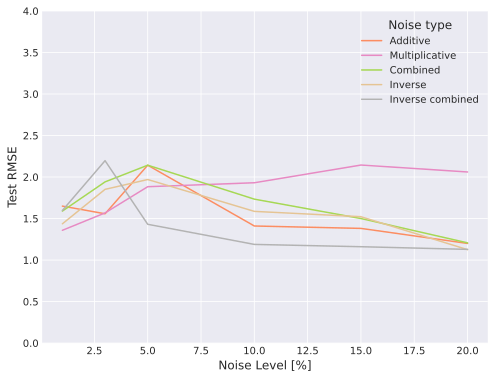

In [68]:
rmse_cols = [c for c in df.columns if 'rmse' in c and 'low' not in c]

# Choose a colormap
cmap_shift = 1 #to seelct darker colors and not whites
colormap = plt.cm.get_cmap('Set2', len(rmse_cols)+cmap_shift)

# Plot
plt.figure(figsize=(8, 6))
for i, noise_type in enumerate(rmse_cols):
    plt.plot(df['Noise Level'], df[f'{noise_type}'] , label=noise_type, color=colormap(i+cmap_shift)) #+df[f'{noise_type}low']
plt.xlabel('Noise Level [%]')
plt.ylabel('Test RMSE')
plt.ylim(0,4)

# Set x-ticks to specific values
xticks = [1, 3, 5, 10, 15, 20]
plt.xticks(xticks)

# Create the legend
legend_labels = ['Additive', 'Multiplicative', 'Combined', 'Inverse', 'Inverse combined']  # Customize these labels as needed
plt.legend(title='Noise type', labels=legend_labels, fontsize=10, title_fontsize='12')

plt.savefig('manuscript_figures/noise_models_rmse_xtick.png')

/tmp/ipykernel_2814361/3618317650.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('Set2', len(rmse_cols)+cmap_shift)


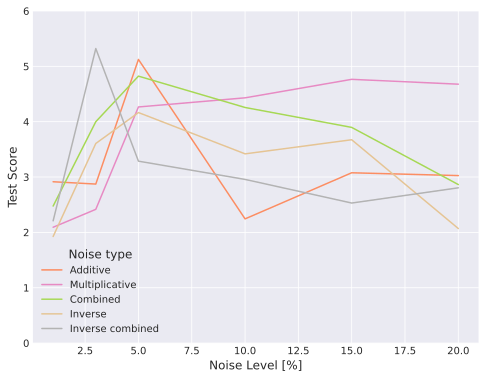

In [82]:
noise_types =['additive', 'multiplicative', 'combined', 'inverse', 'inverse_combined']

# Choose a colormap
cmap_shift = 1 #to seelct darker colors and not whites
colormap = plt.cm.get_cmap('Set2', len(rmse_cols)+cmap_shift)

# Plot
plt.figure(figsize=(8, 6))
for i, noise_type in enumerate(noise_types):
    score = df[f'{noise_type}_rmse'] - df[f'{noise_type}_std/r2'] -df[f'{noise_type}_slope'] + df[f'{noise_type}_intercept'] 
    plt.plot(df['Noise Level'], score, label=noise_type, color=colormap(i+cmap_shift)) #+df[f'{noise_type}low']
plt.xlabel('Noise Level [%]')
plt.ylabel('Test Score')
plt.ylim(0,6)

# Set x-ticks to specific values
#xticks = [1, 3, 5, 10, 15, 20]
#plt.xticks(xticks)

# Create the legend
legend_labels = ['Additive', 'Multiplicative', 'Combined', 'Inverse', 'Inverse combined']  # Customize these labels as needed
plt.legend(title='Noise type', labels=legend_labels, fontsize=10, title_fontsize='12')

plt.savefig('manuscript_figures/noise_models_score.png')

/tmp/ipykernel_2814361/3125826393.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('Set2', len(rmse_cols)+cmap_shift)


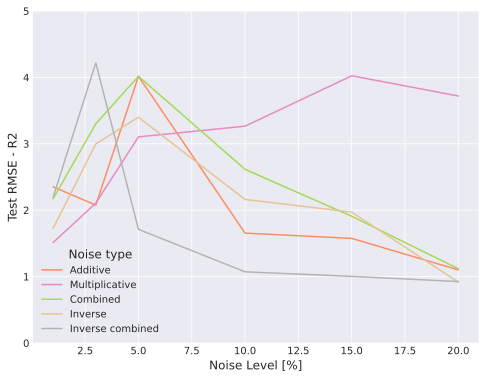

In [78]:
noise_types =['additive', 'multiplicative', 'combined', 'inverse', 'inverse_combined']

# Choose a colormap
cmap_shift = 1 #to seelct darker colors and not whites
colormap = plt.cm.get_cmap('Set2', len(rmse_cols)+cmap_shift)

# Plot
plt.figure(figsize=(8, 6))
for i, noise_type in enumerate(noise_types):
    score = df[f'{noise_type}_rmse'] - df[f'{noise_type}_std/r2'] 
    plt.plot(df['Noise Level'], score, label=noise_type, color=colormap(i+cmap_shift)) #+df[f'{noise_type}low']
plt.xlabel('Noise Level [%]')
plt.ylabel('Test RMSE - R2')
plt.ylim(0,5)

# Set x-ticks to specific values
#xticks = [1, 3, 5, 10, 15, 20]
#plt.xticks(xticks)

# Create the legend
legend_labels = ['Additive', 'Multiplicative', 'Combined', 'Inverse', 'Inverse combined']  # Customize these labels as needed
plt.legend(title='Noise type', labels=legend_labels, fontsize=10, title_fontsize='12')

plt.savefig('manuscript_figures/noise_models_rmser2.png')

/tmp/ipykernel_2814361/3169022985.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('Set2', len(rmse_cols)+cmap_shift)


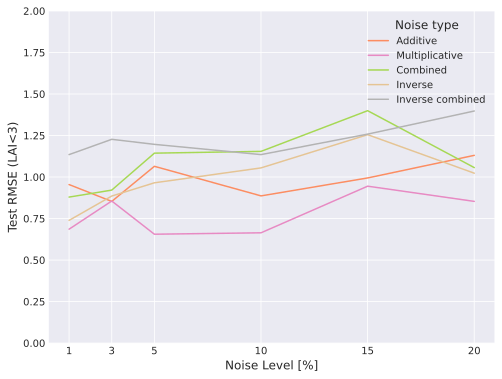

In [85]:
noise_types =['additive', 'multiplicative', 'combined', 'inverse', 'inverse_combined']

# Choose a colormap
cmap_shift = 1 #to seelct darker colors and not whites
colormap = plt.cm.get_cmap('Set2', len(rmse_cols)+cmap_shift)

# Plot
plt.figure(figsize=(8, 6))
for i, noise_type in enumerate(noise_types):
    score = df[f'{noise_type}_rmselow']
    plt.plot(df['Noise Level'], score, label=noise_type, color=colormap(i+cmap_shift)) #+df[f'{noise_type}low']
plt.xlabel('Noise Level [%]')
plt.ylabel('Test RMSE (LAI<3)')
plt.ylim(0,2)

# Set x-ticks to specific values
xticks = [1, 3, 5, 10, 15, 20]
plt.xticks(xticks)

# Create the legend
legend_labels = ['Additive', 'Multiplicative', 'Combined', 'Inverse', 'Inverse combined']  # Customize these labels as needed
plt.legend(title='Noise type', labels=legend_labels, fontsize=10, title_fontsize='12')

plt.savefig('manuscript_figures/noise_models_rmselow_xtick.png')

/tmp/ipykernel_2814361/976009907.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('Set2', len(rmse_cols)+cmap_shift)


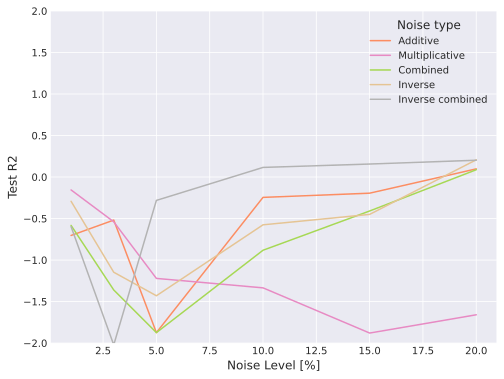

In [90]:
noise_types =['additive', 'multiplicative', 'combined', 'inverse', 'inverse_combined']

# Choose a colormap
cmap_shift = 1 #to seelct darker colors and not whites
colormap = plt.cm.get_cmap('Set2', len(rmse_cols)+cmap_shift)

# Plot
plt.figure(figsize=(8, 6))
for i, noise_type in enumerate(noise_types):
    score = df[f'{noise_type}_std/r2']
    plt.plot(df['Noise Level'], score, label=noise_type, color=colormap(i+cmap_shift)) #+df[f'{noise_type}low']
plt.xlabel('Noise Level [%]')
plt.ylabel('Test R2')
plt.ylim(-2,2)

# Set x-ticks to specific values
#xticks = [1, 3, 5, 10, 15, 20]
#plt.xticks(xticks)

# Create the legend
legend_labels = ['Additive', 'Multiplicative', 'Combined', 'Inverse', 'Inverse combined']  # Customize these labels as needed
plt.legend(title='Noise type', labels=legend_labels, fontsize=10, title_fontsize='12')

plt.savefig('manuscript_figures/noise_models_r2.png')

# Model performances
- compare no soil vs soil

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from argparse import ArgumentParser
import yaml
from typing import Dict, Tuple, Union, Any
import pickle
import torch
from pathlib import Path
import os
import matplotlib.pyplot as plt
from pathlib import Path
import sys
base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent
sys.path.insert(0, str(base_dir))
from models import MODELS
import seaborn as sns

In [3]:
# Load config file

config_path = "../configs/config_NN.yaml"
with open(config_path, "r") as config_file:
      config = yaml.safe_load(config_file)

In [4]:
def prepare_data(config: dict) -> Union[Tuple[np.array, np.array, np.array, np.array], None]:
  ''' 
  Load data and prepare training and testing sets

  :param config: dictionary of configuration parameters
  :returns: X pd.DataFrame and y pd.Series for training and test sets 
  '''
  data_path = '../' + config['Data']['test_data_path']

  if isinstance(data_path, str):
    df = pd.read_pickle(data_path)
    X = df[config['Data']['train_cols']]
    y = df[config['Data']['target_col']]

    if config['Model']['name'] == 'RF':
      # Add derivatives
      derivatives = X.diff(axis=1)
      for col in X.columns[1:]:
          X[col + '_derivative'] = derivatives[col]
      # Add NDVI
      X['ndvi'] = (X['B08'] - X['B04'])/(X['B08'] + X['B04'])

    if config['Data']['normalize']:
      # Load scaler
      scaler_path = '../' + config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
      with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
      # Normalize
      X = scaler.transform(X)
      return X, y.values
      #X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=config['Data']['test_size'], random_state=config['Seed'])
      #print('here')
      #return X_test, y_test
    else:
      return X, y.values

  elif isinstance(data_path, list):
    # Assuming all files in the list are pickled DataFrames
    dfs = [pd.read_pickle(path) for path in data_path]
    concatenated_df = pd.concat(dfs, axis=0, ignore_index=True)
    X = concatenated_df[config['Data']['train_cols']] #  concatenated_df[config['Data']['train_cols']]
    y = concatenated_df[config['Data']['target_col']] #  concatenated_df[config['Data']['target_col']]

    if config['Model']['name'] == 'RF':
      # Add derivatives
      derivatives = X.diff(axis=1)
      for col in X.columns[1:]:
          X[col + '_derivative'] = derivatives[col]
      # Add NDVI
      X['ndvi'] = (X['B08'] - X['B04'])/(X['B08'] + X['B04'])
      
    if config['Data']['normalize']:
      # Load scaler
      scaler_path = '../' + config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
      with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
      # Normalize
      X = scaler.transform(X)
      return X, y.values
    else:
      return X, y.values

  else:
      return None

X_test, y_test = prepare_data(config)

# Move data to CUDA if GPUs requested and available
device = torch.device('cuda' if config['Model'].get('gpu') and torch.cuda.is_available() else 'cpu')
if device == torch.device('cuda'):
    X_test, y_test = (
        torch.FloatTensor(X_test).to(device),
        torch.FloatTensor(y_test).view(-1, 1).to(device)
    )

In [5]:
#############################################
# MODEL
save_model = config['Model'].pop('save')
model_name = config['Model']['name']
model_filename = '../' + config['Model'].pop('save_path') 
with open(model_filename, 'rb') as f:
  model = pickle.load(f)

# Move model to CUDA if GPUs are available
if device == torch.device('cuda'):
    model.to(device)

#############################################
# TEST
if model_name == 'GPR': # Active learning
  y_pred, y_std = model.predict(X_test, return_std=True)
  print('Mean test std', y_std.mean()) 
  model.test_scores(y_test=y_test, y_pred=y_pred, dataset='Val')
else: 
  y_pred = model.predict(X_test=X_test)
  model.test_scores(y_test=y_test, y_pred=y_pred, dataset='Val')

Val RMSE: 1.3341930665545747
Val MAE: 1.0893766371271225
Val R2: -0.11463067136623861
Regression slope: 0.8469660379923701
Regression intercept: 0.5426410762889002
Val rmselow: 0.902810673920816
Val fabio: 1.0308416792713844


In [6]:
# Move y_pred to CPU if it's on CUDA device
if isinstance(y_pred, torch.Tensor) and y_pred.device.type == 'cuda':
    y_pred = y_pred.cpu().detach().numpy()
if isinstance(y_test, torch.Tensor) and y_test.device.type == 'cuda':
    y_test = y_test.cpu().detach().numpy()
          
slope, intercept = np.polyfit(y_test.flatten(), y_pred.flatten(), 1)

In [7]:
slope

0.8469660379923701

In [8]:
intercept

0.5426410762889002

In [111]:
def plot_preds_simple(y_test, y_pred, title, textstr, savename):

  plt.style.use('seaborn-v0_8-darkgrid') 

  fig, ax = plt.subplots(figsize=(8,8))
  ax.scatter(y_test, y_pred)
  ax.set_xlabel('Validation LAI', fontsize=16)
  ax.set_ylabel('Predicted LAI', fontsize=16)
  #ax.set_title(f'{title}', fontsize=18)
  ax.set_xlim((0,8))
  ax.set_ylim((0,8))
  ax.tick_params(axis='both', which='major', labelsize=16)

  # Plot y=x line
  ax.plot([0, 8], [0, 8], color='gray', linestyle='--', label='1:1 fit')

  # Plot regression line
  xseq = np.linspace(0, 8, num=100)
  ax.plot(xseq, intercept + slope * xseq, color="r", linestyle='--', label='Linear fit')
  ax.legend(fontsize=16)

  # TO DO: add R2 and RMSE to plot
  props = dict(boxstyle='round', facecolor='white', alpha=0.5)
  ax.text(0.03, 0.70, textstr, transform=ax.transAxes, fontsize=16,
          bbox=props)

  plt.savefig(f'manuscript_figures/{savename}_simple.png')
  plt.show()

  return


def plot_preds_fancy(y_test, y_pred, title, textstr, savename):
        
        # Create a DataFrame
        data = pd.DataFrame({'Validation LAI': y_test, 'Predicted LAI': y_pred.flatten()})

        # Set the style
        plt.style.use('seaborn-v0_8-darkgrid')

        # Create lmplot without regression line and legend
        g = sns.lmplot(x='Validation LAI', y='Predicted LAI', data=data, height=8, aspect=1, 
                scatter_kws={'s': 50, 'alpha': 1}, fit_reg=False, legend=True)

        # Manually plot the regression line
        ax = g.ax
        sns.regplot(x='Validation LAI', y='Predicted LAI', data=data, ax=ax, scatter=False, 
                line_kws={'color': 'red'}, label='Linear fit')


        # Customize the plot
        ax.set_xlabel('Validation LAI', fontsize=16)
        ax.set_ylabel('Predicted LAI', fontsize=16)
        #ax.set_title(f'{title}', fontsize=18)
        ax.set_xlim((0, 7))
        ax.set_ylim((0, 7))
        ax.tick_params(axis='both', which='major', labelsize=16)

        # Plot y=x line and capture its handle
        line_1to1, = ax.plot([0, 8], [0, 8], color='gray', linestyle='--', label='1:1 fit')

        # Add text box
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        ax.text(0.03, 0.75, textstr, transform=ax.transAxes, fontsize=16, bbox=props)

        # Add legend
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(fontsize=16)

        plt.tight_layout()
        plt.savefig(f'manuscript_figures/{savename}_fancy.png')
        plt.show()

        return

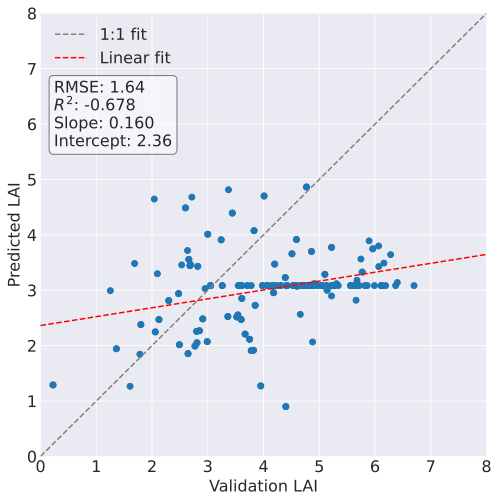

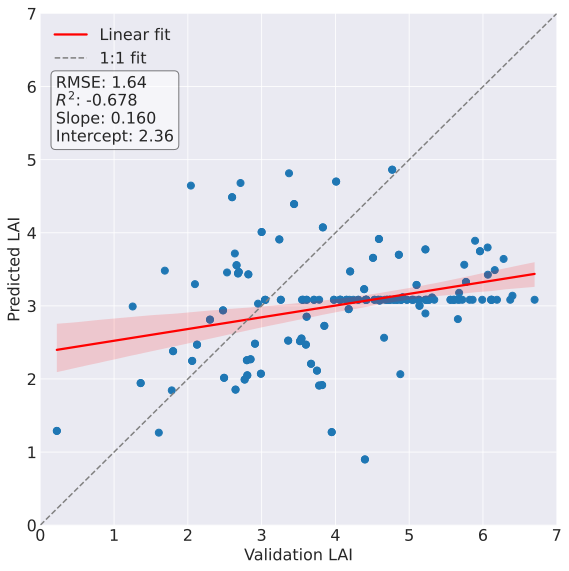

In [95]:
# Testing new model with seed 13

plot_preds_simple(y_test, y_pred, 'Neural network with no soil data', 'RMSE: 1.64 \n$R^2$: -0.678 \nSlope: 0.160 \nIntercept: 2.36', 'NN_nosoil22_debug')
plot_preds_fancy(y_test, y_pred, 'Neural network with no soil data', 'RMSE: 1.64 \n$R^2$: -0.678 \nSlope: 0.160 \nIntercept: 2.36', 'NN_nosoil22_debug')

In [ ]:
# NN with no soil

plot_preds_simple(y_test, y_pred, 'Neural network with no soil data', 'RMSE: 1.24 \n$R^2$: 0.0381 \nSlope: 0.449 \nIntercept: 1.50', 'NN_nosoil22')
plot_preds_fancy(y_test, y_pred, 'Neural network with no soil data', 'RMSE: 1.24 \n$R^2$: 0.0381 \nSlope: 0.449 \nIntercept: 1.50', 'NN_mosoil22')

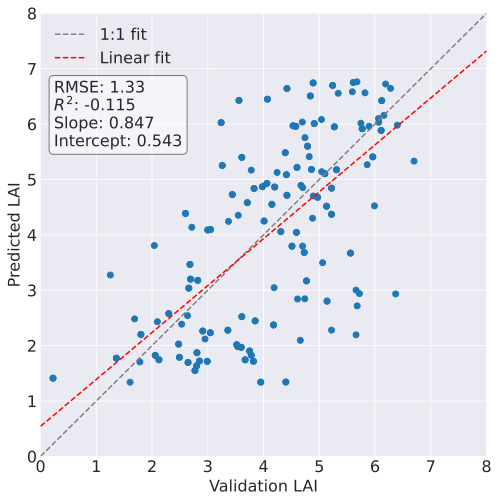

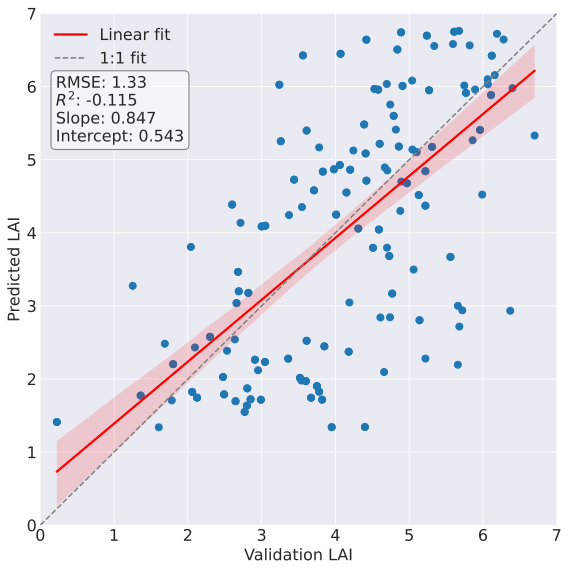

In [22]:
# Tuned NN with soil and noise

plot_preds_simple(y_test, y_pred, 'Tuned neural network with soil and noise data', 'RMSE: 1.33 \n$R^2$: -0.115 \nSlope: 0.847 \nIntercept: 0.543', 'NN_soil22noise_tuned_notitle')
plot_preds_fancy(y_test, y_pred, 'Tuned neural network with soil and noise data', 'RMSE: 1.33 \n$R^2$: -0.115 \nSlope: 0.847 \nIntercept: 0.543', 'NN_soil22noise_tuned_notitle')

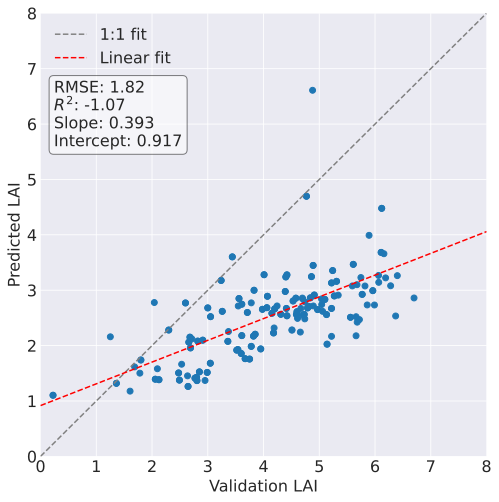

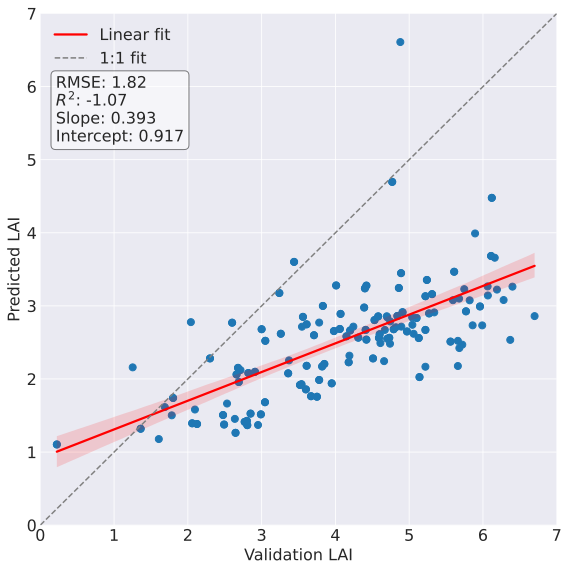

In [11]:
# NN with soil  

plot_preds_simple(y_test, y_pred, 'Neural network with soil data', 'RMSE: 1.82 \n$R^2$: -1.07 \nSlope: 0.393 \nIntercept: 0.917', 'NN_soilscaled22_notitle')
plot_preds_fancy(y_test, y_pred, 'Neural network with soil data', 'RMSE: 1.82 \n$R^2$: -1.07 \nSlope: 0.393 \nIntercept: 0.917', 'NN_soilscaled22_notitle')

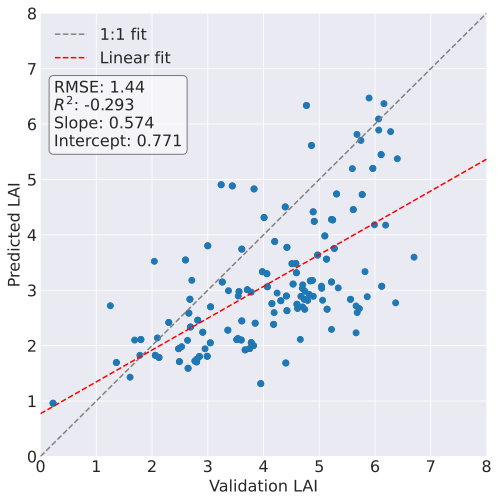

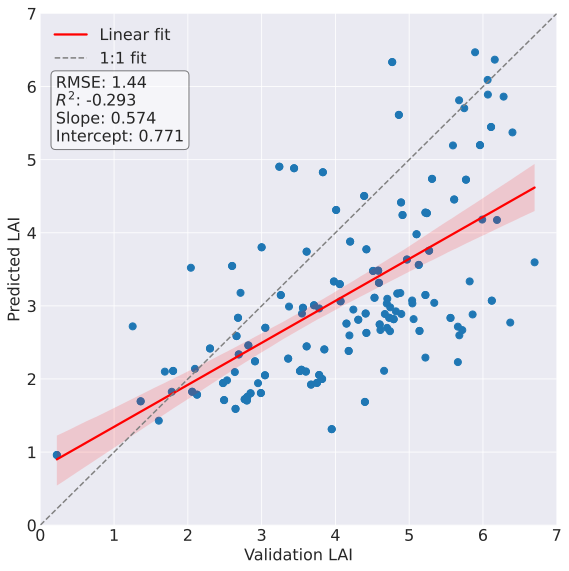

In [112]:
# NN with soil and noise

plot_preds_simple(y_test, y_pred, 'Neural network with soil and noise data', 'RMSE: 1.44 \n$R^2$: -0.293 \nSlope: 0.574 \nIntercept: 0.771', 'NN_soil22inv1noisev2')
plot_preds_fancy(y_test, y_pred, 'Neural network with soil and noise data', 'RMSE: 1.44 \n$R^2$: -0.293 \nSlope: 0.574 \nIntercept: 0.771', 'NN_soil22inv1noisev2')

# SNAP LAI predictions

- scatter plot

In [9]:
import sys
base_dir = str(Path(os.path.dirname(os.path.realpath("__file__"))).parent.parent) + '/SNAP_LAI'
sys.path.append(base_dir)
import biophys 
from sklearn.metrics import mean_squared_error, r2_score

In [10]:
# Run SNAP on validation set

data_path = '../../results/validation_data_extended_angles.pkl'
df = pd.read_pickle(data_path)
df = df[~df.lai.isna()]

# Compute LAI
df_lai = biophys.run_snap_biophys(df, "LAI")

In [11]:
df

B02     B03     B04     B05     B06     B07     B08     B8A     B11  \
2    0.0198  0.0488  0.0295  0.0788  0.2574  0.3147  0.3184  0.3346  0.1394   
4    0.0322  0.0490  0.0340  0.0715  0.2518  0.3346  0.3236  0.3461  0.1229   
5    0.0556  0.0857  0.0572  0.1342  0.3260  0.3996  0.4120  0.4260  0.1929   
8    0.0164  0.0438  0.0268  0.0725  0.2618  0.3215  0.3240  0.3400  0.1333   
10   0.0280  0.0455  0.0290  0.0717  0.2449  0.3348  0.3316  0.3515  0.1148   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
164  0.0200  0.0520  0.0336  0.0967  0.2911  0.3568  0.3760  0.3707  0.1598   
165  0.0168  0.0531  0.0325  0.0856  0.3058  0.3825  0.3956  0.4004  0.1524   
166  0.0208  0.0530  0.0390  0.0941  0.2947  0.3624  0.3756  0.3729  0.1590   
167  0.0215  0.0530  0.0384  0.0964  0.2982  0.3608  0.3788  0.3743  0.1612   
168  0.0182  0.0510  0.0362  0.0889  0.2894  0.3742  0.3660  0.3641  0.1589   

        B12                  geometry                 date  view_zenith  \
2    0.0760  POINT (9.06923 47.66701)  2022-05-11 09:48:44     0.052021   
4    0.0693  POINT (9.06921 47.66710)  2022-05-19 13:14:04     0.181030   
5    0.1080  POINT (9.06926 47.66706)  2022-06-15 11:45:12     0.051362   
8    0.0664  POINT (9.06856 47.66724)  2022-05-11 09:58:08     0.052021   
10   0.0624  POINT (9.06850 47.66722)  2022-05-19 13:20:06     0.181030   
..      ...                       ...                  ...          ...   
164  0.0837  POINT (8.91404 47.48322)  2023-04-05 10:42:00     0.144737   
165  0.0792  POINT (8.91404 47.48269)  2023-04-05 10:55:00     0.144737   
166  0.0817  POINT (8.91307 47.48278)  2023-04-05 11:07:00     0.144737   
167  0.0843  POINT (8.91161 47.48294)  2023-04-05 11:22:00     0.144737   
168  0.0839  POINT (8.91100 47.48293)  2023-04-05 11:35:00     0.144737   

     sun_zenith  relative_azimuth       lai         location  \
2      0.543439          0.098418  2.770000       Arenenberg   
4      0.501150          4.032842  3.670000       Arenenberg   
5      0.459681          6.219639  3.780000       Arenenberg   
8      0.543439          0.098418  2.800000       Arenenberg   
10     0.501150          4.032842  3.540000       Arenenberg   
..          ...               ...       ...              ...   
164    0.749782          0.923854  2.058469  SwissFutureFarm   
165    0.749782          0.923854  3.045552  SwissFutureFarm   
166    0.749782          0.923854  2.491247  SwissFutureFarm   
167    0.749782          0.923854  1.360373  SwissFutureFarm   
168    0.749782          0.923854  2.124542  SwissFutureFarm   

     green_canopy_cover  snap_LAI  
2                   NaN  1.509612  
4                   NaN  1.778226  
5                   NaN  1.377056  
8                   NaN  1.639297  
10                  NaN  1.894320  
..                  ...       ...  
164           58.043806  2.122995  
165           66.980797  2.526346  
166           57.051915  2.157363  
167           53.893151  2.147525  
168           56.806914  2.167016  

[212 rows x 19 columns]

In [12]:
y_test_snap = df_lai.lai.values
y_pred_snap = df_lai.snap_LAI.values

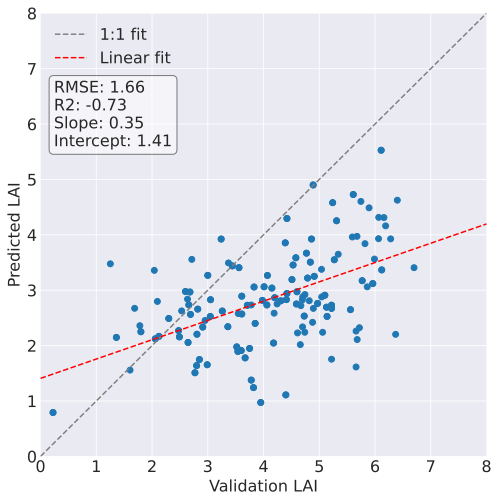

In [63]:
plt.style.use('seaborn-v0_8-darkgrid') 

y_test_snap = df_lai.lai.values
y_pred_snap = df_lai.snap_LAI.values

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(y_test_snap, y_pred_snap)
ax.set_xlabel('Validation LAI', fontsize=16)
ax.set_ylabel('Predicted LAI', fontsize=16)
#ax.set_title(f'{title}', fontsize=18)
ax.set_xlim((0,8))
ax.set_ylim((0,8))
ax.tick_params(axis='both', which='major', labelsize=16)

# Plot y=x line
ax.plot([0, 8], [0, 8], color='gray', linestyle='--', label='1:1 fit')

# Plot regression line
slope, intercept = np.polyfit(y_test_snap.flatten(), y_pred_snap.flatten(), 1)
xseq = np.linspace(0, 8, num=100)
ax.plot(xseq, intercept + slope * xseq, color="r", linestyle='--', label='Linear fit')
ax.legend(fontsize=16)

# Compute RMSE and R2
rmse = mean_squared_error(y_test_snap, y_pred_snap, squared=False)
r2 = r2_score(y_test_snap, y_pred_snap)

# Text for displaying on plot
textstr = f'RMSE: {rmse:.2f}\nR2: {r2:.2f}\nSlope: {slope:.2f}\nIntercept: {intercept:.2f}'

# TO DO: add R2 and RMSE to plot
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.03, 0.70, textstr, transform=ax.transAxes, fontsize=16,
        bbox=props)

plt.savefig(f'manuscript_figures/SNAP_preds_simple.png')
plt.show()

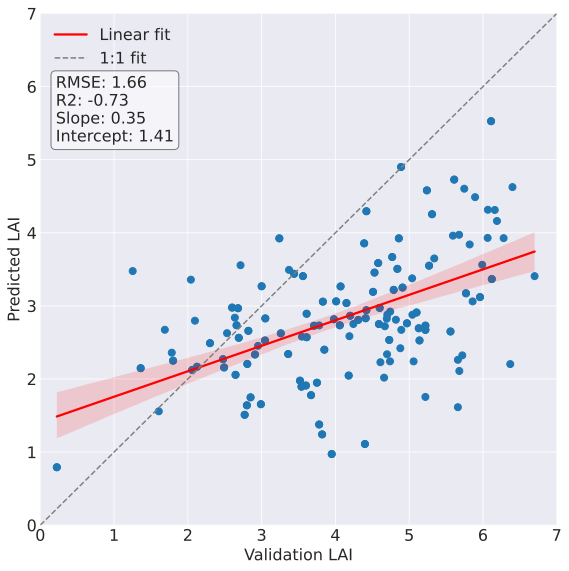

In [62]:
# Create a DataFrame
data = pd.DataFrame({'Validation LAI': y_test_snap, 'Predicted LAI': y_pred_snap.flatten()})

# Set the style
plt.style.use('seaborn-v0_8-darkgrid')

# Create lmplot without regression line and legend
g = sns.lmplot(x='Validation LAI', y='Predicted LAI', data=data, height=8, aspect=1, 
        scatter_kws={'s': 50, 'alpha': 1}, fit_reg=False, legend=True)

# Manually plot the regression line
ax = g.ax
sns.regplot(x='Validation LAI', y='Predicted LAI', data=data, ax=ax, scatter=False, 
        line_kws={'color': 'red'}, label='Linear fit')


# Customize the plot
ax.set_xlabel('Validation LAI', fontsize=16)
ax.set_ylabel('Predicted LAI', fontsize=16)
#ax.set_title(f'{title}', fontsize=18)
ax.set_xlim((0, 7))
ax.set_ylim((0, 7))
ax.tick_params(axis='both', which='major', labelsize=16)

# Plot y=x line and capture its handle
line_1to1, = ax.plot([0, 8], [0, 8], color='gray', linestyle='--', label='1:1 fit')

# Add text box
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.03, 0.75, textstr, transform=ax.transAxes, fontsize=16, bbox=props)

# Add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(fontsize=16)

plt.tight_layout()
plt.savefig(f'manuscript_figures/SNAP_preds_fancy.png')
plt.show()

# Compare SNAP LAI to NN tuned model

In [13]:
data_snap = pd.DataFrame({'Validation LAI': y_test_snap, 'Predicted LAI': y_pred_snap.flatten(), 'dataset': ['SNAP']*len(y_test_snap)})
data_nn = pd.DataFrame({'Validation LAI': y_test, 'Predicted LAI': y_pred.flatten(), 'dataset': ['NN']*len(y_test)})

# Concatenate both DataFrames
df_combined = pd.concat([data_snap, data_nn])

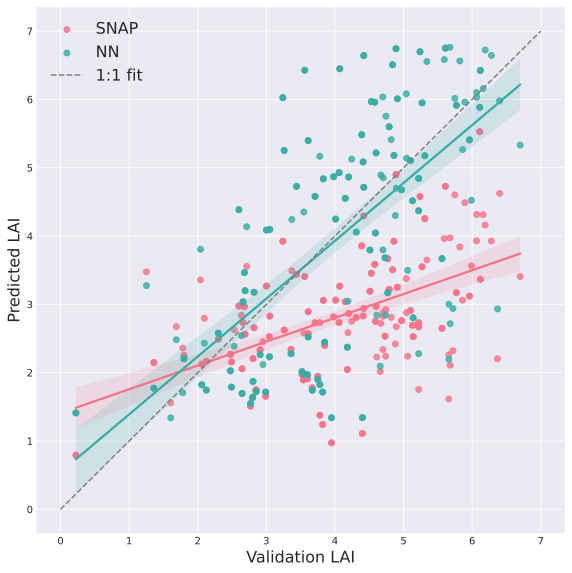

In [16]:
plt.style.use('seaborn-v0_8-darkgrid')

g = sns.lmplot(x='Validation LAI', y='Predicted LAI', data=df_combined, hue='dataset', height=8, aspect=1, palette='husl', legend=False) #husl palette good too

# Customize the plot
plt.xlabel('Validation LAI', fontsize=16)
plt.ylabel('Predicted LAI', fontsize=16)

# Plot the 1:1 fit line
plt.plot([0, 7], [0, 7], color='gray', linestyle='--', label='1:1 fit')

# Add legend
plt.legend(fontsize=16)
plt.savefig('manuscript_figures/SNAPvsNN_preds.png')

plt.show()

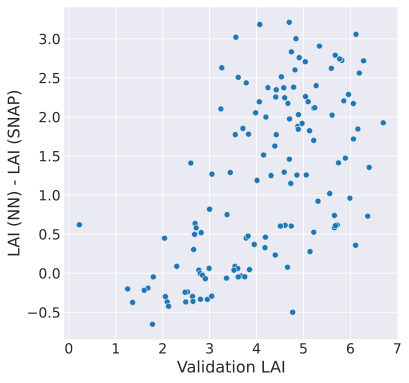

In [37]:
df_diff = pd.DataFrame({'Validation LAI': y_test, 'Diff': data_nn['Predicted LAI']-data_snap['Predicted LAI']})

# Set the style
plt.style.use('seaborn-v0_8-darkgrid')

plt.figure(figsize=(6,6))
# Plot the scatter plot with color mapped to the absolute difference
g = sns.scatterplot(x='Validation LAI', y='Diff', data=df_diff)

# Customize the plot
plt.xlabel('Validation LAI', fontsize=16)
plt.ylabel('LAI (NN) - LAI (SNAP)', fontsize=16)

# Add legend
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('manuscript_figures/SNAP_NN_diff_scatter.png')

plt.show()


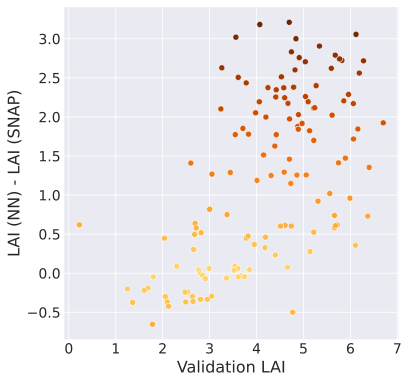

In [36]:
from matplotlib.colors import LinearSegmentedColormap

# Sample data
df_diff = pd.DataFrame({
    'Validation LAI': y_test, 
    'Diff': data_nn['Predicted LAI'] - data_snap['Predicted LAI']
})

# Compute the absolute differences
df_diff['Abs Diff'] = df_diff['Diff'].abs()

# Set the style
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(6,6))

cmap = plt.get_cmap('YlOrBr') 
colors = cmap(np.linspace(0.3, 1, 100))  # Skip the lighter colors by starting at 0.3
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# Plot the scatter plot with color mapped to the absolute difference
g = sns.scatterplot(
    x='Validation LAI', 
    y='Diff', 
    data=df_diff, 
    hue='Abs Diff', 
    palette=custom_cmap,
    legend=False # to disable the default legend
)

# Customize the plot
plt.xlabel('Validation LAI', fontsize=16)
plt.ylabel('LAI (NN) - LAI (SNAP)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('manuscript_figures/SNAP_NN_diff_scatter_color.png')
plt.show()

# LAI seen from satellites

In [14]:
import contextily as cx
import xarray as xr
import xvec
import rioxarray
from matplotlib.ticker import MaxNLocator
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.cm as cm

[ 352169.08496303 5203528.1409557   354758.72139843 5206287.24357044]


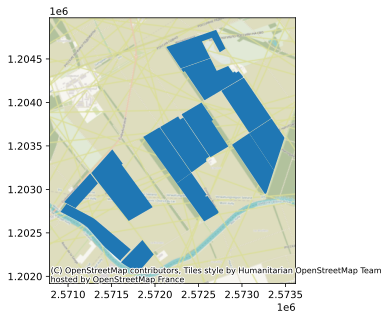

In [15]:
# Get data around SwissFutureFarm

shp = '../../data/Witzwil.shp'
gdf = gpd.read_file(shp)

plt.style.use('default')
fig, ax = plt.subplots()
gdf.plot(ax=ax)
cx.add_basemap(ax, crs=gdf.crs)

bounds = gdf.to_crs(32632).total_bounds
print(bounds)

In [16]:
# Find paths of data that falls in bounds

data_path = os.path.expanduser('~/mnt/eo-nas1/data/satellite/sentinel2/raw/CH/')
data_files = [f for f in os.listdir(data_path) if f.endswith('zarr')]
df_zarr = pd.DataFrame(data_files, columns=['file'])

def extract_minx_maxy(file):
    parts = file.split('_')
    minx = int(parts[1])
    maxy = int(parts[2])
    maxx = minx + 1280
    miny = maxy - 1280
    return minx, miny, maxx, maxy

# Apply the function to extract minx and maxy into new columns
df_zarr[['minx', 'miny', 'maxx', 'maxy']] = df_zarr['file'].apply(lambda x: pd.Series(extract_minx_maxy(x)))

In [17]:
# Filter for location

df_farm = df_zarr[
    (df_zarr['maxx'] >= bounds[0]) &  # The box's maxx should be greater than or equal to bbox's minx
    (df_zarr['minx'] <= bounds[2]) &  # The box's minx should be less than or equal to bbox's maxx
    (df_zarr['maxy'] >= bounds[1]) &  # The box's maxy should be greater than or equal to bbox's miny
    (df_zarr['miny'] <= bounds[3])    # The box's miny should be less than or equal to bbox's maxy
]

# Filter for year
df_farm = df_farm[df_farm['file'].str.contains('202201')]

In [18]:
# Load data

ds = []
for cube in df_farm.file:
  ds_loaded = xr.open_zarr(data_path + cube).compute()
  ds.append(ds_loaded)

mc = xr.merge(ds)

In [19]:
# Mask to keep only field data

nonspatial_vars = ['mean_sensor_azimuth', 'mean_sensor_zenith', 'mean_solar_azimuth', 'mean_solar_zenith', 'product_uri']
masked_mc = mc.rename({'lon': 'x', 'lat': 'y'}).rio.write_crs(32632).drop_vars(nonspatial_vars).rio.clip(gdf.to_crs(32632).geometry)

In [24]:
masked_mc = masked_mc.drop_duplicates(dim='time', keep='first')

In [26]:
mc_timeseries

<xarray.Dataset> Size: 9MB
Dimensions:      (y: 275, x: 258, time: 2)
Coordinates:
  * y            (y) float64 2kB 5.204e+06 5.204e+06 ... 5.206e+06 5.206e+06
  * x            (x) float64 2kB 3.522e+05 3.522e+05 ... 3.547e+05 3.548e+05
  * time         (time) datetime64[ns] 16B 2022-06-28 2022-07-03
    spatial_ref  int64 8B 0
Data variables: (12/16)
    s2_AOT       (time, y, x) float32 568kB nan nan nan nan ... nan nan nan nan
    s2_B01       (time, y, x) float32 568kB nan nan nan nan ... nan nan nan nan
    s2_B02       (time, y, x) float32 568kB nan nan nan nan ... nan nan nan nan
    s2_B03       (time, y, x) float32 568kB nan nan nan nan ... nan nan nan nan
    s2_B04       (time, y, x) float32 568kB nan nan nan nan ... nan nan nan nan
    s2_B05       (time, y, x) float32 568kB nan nan nan nan ... nan nan nan nan
    ...           ...
    s2_B11       (time, y, x) float32 568kB nan nan nan nan ... nan nan nan nan
    s2_B12       (time, y, x) float32 568kB nan nan nan nan ... nan nan nan nan
    s2_B8A       (time, y, x) float32 568kB nan nan nan nan ... nan nan nan nan
    s2_SCL       (time, y, x) float32 568kB nan nan nan nan ... nan nan nan nan
    s2_WVP       (time, y, x) float32 568kB nan nan nan nan ... nan nan nan nan
    s2_mask      (time, y, x) float32 568kB nan nan nan nan ... nan nan nan nan
Attributes:
    grid:                     EPSG:32632. Coordinates are upper left corners ...
    history:                  Created by Sélène Ledain on 2024-06-15 02:19:29...
    missing data fill value:  65535
    processing:               Baseline correction, cloud masking, BRDF correc...
    source:                   Microsoft Planetary Computer

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


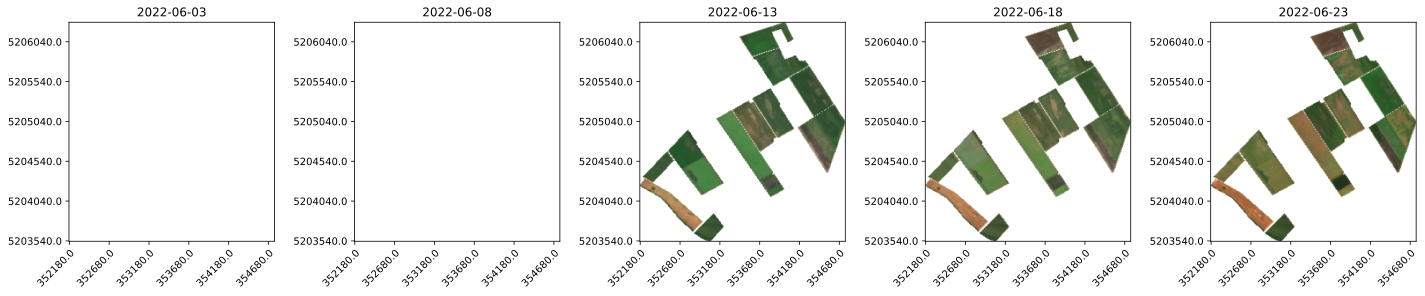

In [27]:
# Plot RGB timeseries
plt.style.use('default')
mc_timeseries = masked_mc.sel(time=slice('2022-06-01', '2022-06-30'))


#mc_timeseries = mc_timeseries.where(mc_timeseries != 65535, np.nan)

scale_factor = 1.0 / 10000.0  # Scale factor for DN to [0, 1]
r = mc_timeseries['s2_B04'] * scale_factor
g = mc_timeseries['s2_B03'] * scale_factor
b = mc_timeseries['s2_B02'] * scale_factor

# Stack bands into an RGB array
rgb = xr.concat([r, g, b], dim='band').transpose('time', 'y', 'x', 'band')
rgb = rgb.where(~np.isnan(rgb), other=1.0)

# Need to rescale each band to 0-255 and then set the nan values to 255
""" 
max_vals = rgb.max(dim=['time', 'y', 'x'])
min_vals = rgb.min(dim=['time', 'y', 'x'])
rgb_scaled = ((rgb - min_vals) / (max_vals - min_vals)) * 255.0
rgb_scaled = rgb_scaled.where(~rgb_scaled.isnull(), 0)
"""

# Plot each RGB image for the first 5 timestamps
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
brightness = 5

for i in range(5):
    axs[i].imshow(rgb[i].values * brightness, origin='lower')
    axs[i].set_title(f"{str(mc_timeseries.time.values[i]).split('T')[0]}")
    
    # Set extent to match the image dimensions
    axs[i].set_xticks(np.arange(rgb[i].shape[1]))
    axs[i].set_yticks(np.arange(rgb[i].shape[0]))
    
    # Set labels based on the dataset or adjust as needed
    axs[i].set_xticklabels(rgb[i].coords['x'].values)
    axs[i].set_yticklabels(rgb[i].coords['y'].values)
    
    # Customize tick locations and labels
    axs[i].xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    axs[i].yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    
    # Rotate x-axis labels if needed
    plt.setp(axs[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add colorbar for each subplot
    #cbar = fig.colorbar(im, ax=axs[i], orientation='vertical')
    #cbar.set_label('Brightness')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


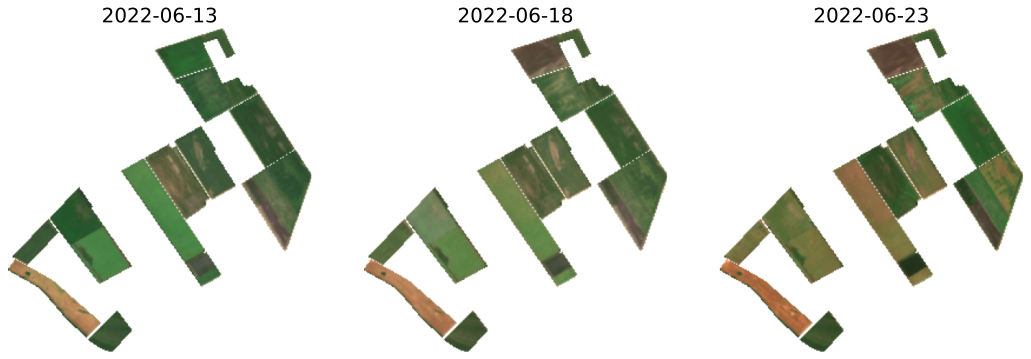

In [34]:
# Plot just images, no grid or axes

# Select a time slice
mc_timeseries = masked_mc.sel(time=slice('2022-06-10', '2022-06-30'))

# Apply scale factor
scale_factor = 1.0 / 10000.0  # Scale factor for DN to [0, 1]
r = mc_timeseries['s2_B04'] * scale_factor
g = mc_timeseries['s2_B03'] * scale_factor
b = mc_timeseries['s2_B02'] * scale_factor

# Stack bands into an RGB array
rgb = xr.concat([r, g, b], dim='band').transpose('time', 'y', 'x', 'band')
rgb = rgb.where(~np.isnan(rgb), other=1.0)

# Plot each RGB image for the first 5 timestamps
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
brightness = 5

for i in range(3):
    axs[i].imshow(rgb[i].values * brightness, origin='lower')
    axs[i].set_title(f"{str(mc_timeseries.time.values[i]).split('T')[0]}", fontsize=20)
    
    # Remove coordinates, grid, and axis labels
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].axis('off')

plt.tight_layout()
plt.savefig('manuscript_figures/RGB_timeseries.png')
plt.show()

## Predict LAI with SNAP
- put pixels in a dataframe, add solar and sensor angles angles
- run model
- reshape and plot


In [35]:
import sys
base_dir = str(Path(os.path.dirname(os.path.realpath("__file__"))).parent.parent) + '/SNAP_LAI'
sys.path.append(base_dir)
import biophys

In [39]:
mc = mc.drop_duplicates(dim='time', keep='first')

In [40]:
masked_mc[['view_zenith', 'sun_zenith']] = mc[['mean_sensor_zenith', 'mean_solar_zenith']]
masked_mc['relative_azimuth'] = mc['mean_solar_azimuth'] - mc['mean_sensor_azimuth']

# Drop duplicate times (for some reason 2 same dates for same tile)
masked_mc = masked_mc.drop_duplicates(dim='time', keep='first')

# Convert to dataframe
df = masked_mc.to_dataframe().reset_index()
df_snap = df[['s2_B03', 's2_B04', 's2_B05', "s2_B06", "s2_B07", "s2_B8A", "s2_B11", "s2_B12", 'view_zenith', 'sun_zenith', 'relative_azimuth']]
df_snap = df_snap.rename(columns={'s2_B03':"B03", 's2_B04':"B04", 's2_B05':"B05", "s2_B06":"B06", "s2_B07":"B07", "s2_B8A":"B8A", "s2_B11":"B11", "s2_B12":"B12"})

# Leave out 65535 rows
df_snap[df_snap == 65535] = np.nan
df_snap[["B03", "B04", "B05", "B06", "B07", "B8A", "B11", "B12"]] = df_snap[["B03", "B04", "B05", "B06", "B07", "B8A", "B11", "B12"]]/10000

In [54]:
df_lai = biophys.run_snap_biophys(df_snap, "LAI")

In [56]:
# Reshape DataFrame back to xarray format
df_lai[['time', 'y', 'x']] = df[['time', 'y', 'x']]

df_lai.set_index(['time', 'y', 'x'], inplace=True)
snap_preds = df_lai.to_xarray()

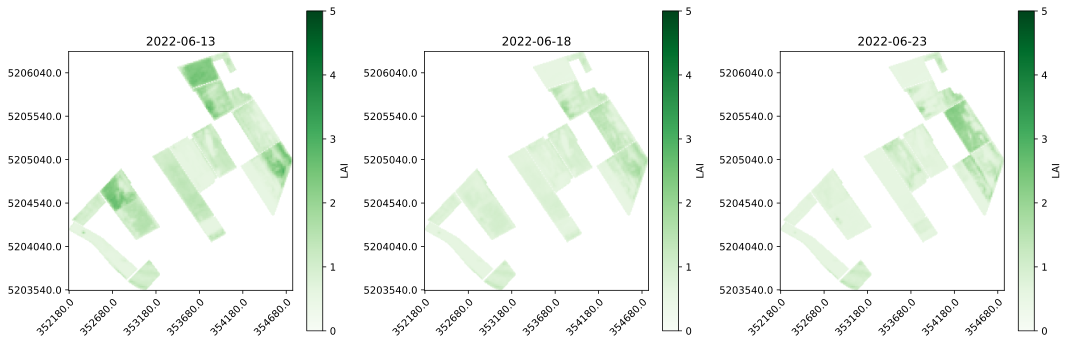

In [61]:
# Plot LAI timeseries

mc_timeseries = snap_preds.sel(time=slice('2022-06-10', '2022-06-30'))

lai = mc_timeseries['snap_LAI']
lai = lai.where(~np.isnan(lai), other=0)

# Plot each RGB image for the first 5 timestamps
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Create a custom colormap that includes white for NaNs
greens_cmap = cm.get_cmap('Greens')
colors = greens_cmap(np.arange(greens_cmap.N))
colors[0] = [1, 1, 1, 1]  # Set the first color (which will correspond to NaNs) to white
custom_cmap = ListedColormap(colors)

for i in range(3):
    im = axs[i].imshow(lai[i].values, origin='lower', cmap=custom_cmap, vmin=0, vmax=5)
    axs[i].set_title(f"{str(mc_timeseries.time.values[i]).split('T')[0]}")
    
    # Set extent to match the image dimensions
    axs[i].set_xticks(np.arange(rgb[i].shape[1]))
    axs[i].set_yticks(np.arange(rgb[i].shape[0]))
    
    # Set labels based on the dataset or adjust as needed
    axs[i].set_xticklabels(rgb[i].coords['x'].values)
    axs[i].set_yticklabels(rgb[i].coords['y'].values)
    
    # Customize tick locations and labels
    axs[i].xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    axs[i].yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    
    # Rotate x-axis labels if needed
    plt.setp(axs[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add colorbar for each subplot
    cbar = fig.colorbar(im, ax=axs[i], orientation='vertical')
    cbar.set_label('LAI')

plt.tight_layout()
plt.show()

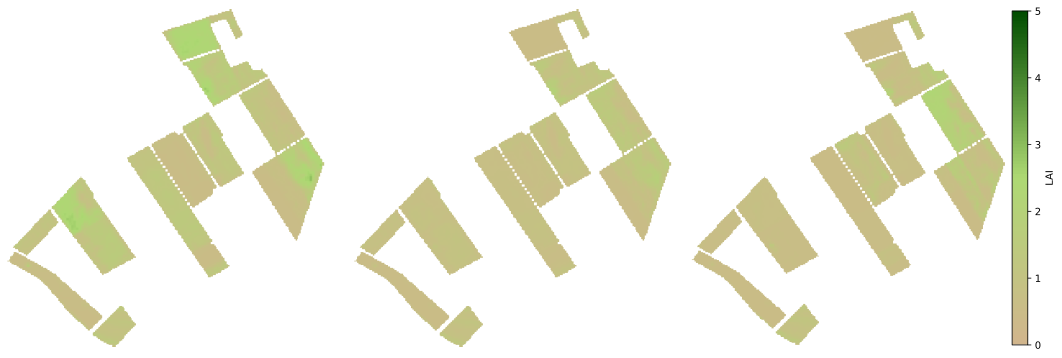

In [90]:
# Plot without grid or axes

from mpl_toolkits.axes_grid1 import make_axes_locatable

mc_timeseries = snap_preds.sel(time=slice('2022-06-10', '2022-06-30'))

# Extract the 'snap_LAI' data and replace NaNs with 0
lai = mc_timeseries['snap_LAI']
#lai = lai.where(~np.isnan(lai), other=0)

#Make custom colormap
colors = [
    (0.82, 0.71, 0.55),  # Light Brown
    (0.68, 0.85, 0.45),  # Light Green
    (0.0, 0.3, 0.0)      # Dark Green
]
n_bins = 100  # Discretize the interpolation into 100 steps
cmap_name = 'brown_green'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Plot each LAI image for the first 3 timestamps
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    im = axs[i].imshow(lai[i].values, origin='lower', cmap=custom_cmap, vmin=0, vmax=5)
    #axs[i].set_title(f"{str(mc_timeseries.time.values[i]).split('T')[0]}")
    
    # Remove axis, ticks, and labels
    axs[i].axis('off')

# Add a single colorbar to the right of the plot
divider = make_axes_locatable(axs[-1])
cax = divider.append_axes("right", size="5%", pad=0.1)

# Use the last image for the colorbar reference
fig.colorbar(im, cax=cax, orientation='vertical').set_label('LAI')

plt.tight_layout()
plt.savefig('manuscript_figures/SNAP_timeseries.png')
plt.show()

# Plot LAI from space - predicted with NN
- reshape to df
- prepare bands for input to normalisation and model
- run model
- reshape and plot

In [68]:
masked_mc = masked_mc.drop_duplicates(dim='time', keep='first')

# Convert to dataframe
df = masked_mc.to_dataframe().reset_index()
df = df.rename(columns={'s2_B02':"B02",'s2_B03':"B03", 's2_B04':"B04", 's2_B05':"B05", "s2_B06":"B06", "s2_B07":"B07", "s2_B08":"B08", "s2_B8A":"B8A", "s2_B11":"B11", "s2_B12":"B12"})

# Leave out 65535 rows
df[df == 65535] = np.nan
df[["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]] = df[["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]]/10000

In [69]:
# Load config file

config_path = "../configs/config_NN.yaml"
with open(config_path, "r") as config_file:
      config = yaml.safe_load(config_file)



def prepare_data(config: dict, df):
  ''' 
  Load data and prepare training and testing sets

  :param config: dictionary of configuration parameters
  :returns: X pd.DataFrame and y pd.Series for training and test sets 
  '''

  X = df[config['Data']['train_cols']]

  if config['Data']['normalize']:
    # Load scaler
    scaler_path = '../' + config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
    with open(scaler_path, 'rb') as f:
      scaler = pickle.load(f)
    # Normalize
    X = scaler.transform(X)
    return X
  else:
    return X


X_test = prepare_data(config, df)

# Move data to CUDA if GPUs requested and available
device = torch.device('cuda' if config['Model'].get('gpu') and torch.cuda.is_available() else 'cpu')
if device == torch.device('cuda'):
    X_test = torch.FloatTensor(X_test).to(device)


#############################################
# MODEL
save_model = config['Model'].pop('save')
model_name = config['Model']['name']
model_filename = '../' + config['Model'].pop('save_path') 
with open(model_filename, 'rb') as f:
  model = pickle.load(f)

# Move model to CUDA if GPUs are available
if device == torch.device('cuda'):
    model.to(device)

#############################################
# TEST
y_pred = model.predict(X_test=X_test)


# Move y_pred to CPU if it's on CUDA device
if isinstance(y_pred, torch.Tensor) and y_pred.device.type == 'cuda':
    y_pred = y_pred.cpu().detach().numpy()

In [70]:
# Shape bakc to xarray and plot predictions

df['lai'] = y_pred.flatten()

df.set_index(['time', 'y', 'x'], inplace=True)
nn_preds = df.to_xarray()

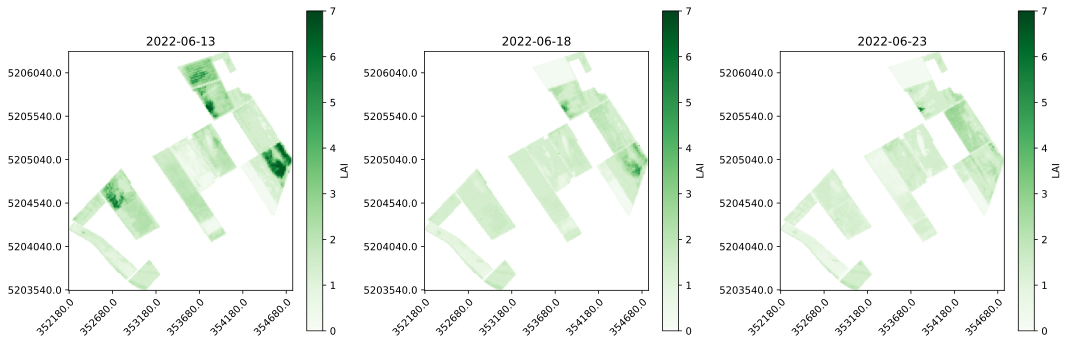

In [74]:
# Plot RGB timeseries

mc_timeseries = nn_preds.sel(time=slice('2022-06-10', '2022-06-30'))

lai = mc_timeseries['lai']
lai = lai.where(~np.isnan(lai), other=0)

# Plot each RGB image for the first 5 timestamps
fig, axs = plt.subplots(1, 3, figsize=(15,5))

# Create a custom colormap that includes white for NaNs
greens_cmap = cm.get_cmap('Greens')
colors = greens_cmap(np.arange(greens_cmap.N))
colors[0] = [1, 1, 1, 1]  # Set the first color (which will correspond to NaNs) to white
custom_cmap = ListedColormap(colors)

for i in range(3):
    im = axs[i].imshow(lai[i].values, origin='lower', cmap=custom_cmap, vmin=0, vmax=7)
    axs[i].set_title(f"{str(mc_timeseries.time.values[i]).split('T')[0]}")
    
    # Set extent to match the image dimensions
    axs[i].set_xticks(np.arange(rgb[i].shape[1]))
    axs[i].set_yticks(np.arange(rgb[i].shape[0]))
    
    # Set labels based on the dataset or adjust as needed
    axs[i].set_xticklabels(rgb[i].coords['x'].values)
    axs[i].set_yticklabels(rgb[i].coords['y'].values)
    
    # Customize tick locations and labels
    axs[i].xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    axs[i].yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    
    # Rotate x-axis labels if needed
    plt.setp(axs[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add colorbar for each subplot
    cbar = fig.colorbar(im, ax=axs[i], orientation='vertical')
    cbar.set_label('LAI')

plt.tight_layout()
plt.show()

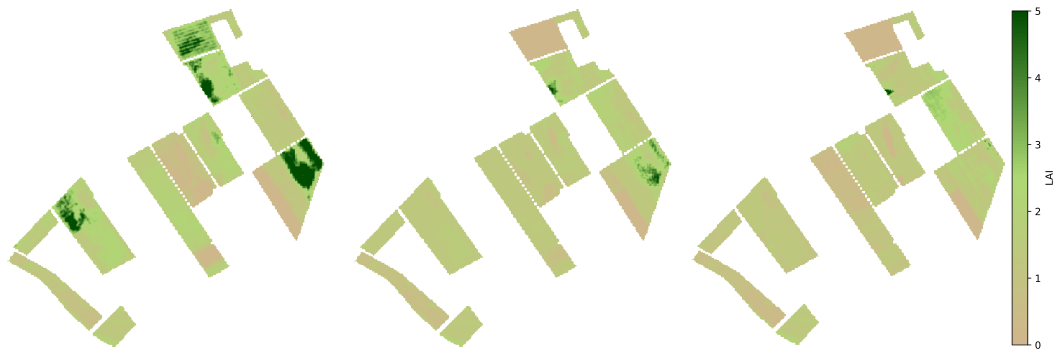

In [89]:
# Plot without grid and axes

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

mc_timeseries = nn_preds.sel(time=slice('2022-06-10', '2022-06-30'))

# Extract the 'snap_LAI' data and replace NaNs with 0
lai = mc_timeseries['lai']
#lai = lai.where(~np.isnan(lai), other=0)

#Make custom colormap
colors = [
    (0.82, 0.71, 0.55),  # Light Brown
    (0.68, 0.85, 0.45),  # Light Green
    (0.0, 0.3, 0.0)      # Dark Green
]
n_bins = 100  # Discretize the interpolation into 100 steps
cmap_name = 'brown_green'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Plot each LAI image for the first 3 timestamps
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    im = axs[i].imshow(lai[i].values, origin='lower', cmap=custom_cmap, vmin=0, vmax=5)
    #axs[i].set_title(f"{str(mc_timeseries.time.values[i]).split('T')[0]}")
    
    # Remove axis, ticks, and labels
    axs[i].axis('off')

# Add a single colorbar to the right of the plot
divider = make_axes_locatable(axs[-1])
cax = divider.append_axes("right", size="5%", pad=0.1)

# Use the last image for the colorbar reference
fig.colorbar(im, cax=cax, orientation='vertical').set_label('LAI')

plt.tight_layout()
plt.savefig('manuscript_figures/NN_timeseries.png')
plt.show()

# Plot the difference between NN and SNAP - seen from space

In [91]:
diff_preds = nn_preds.lai - snap_preds.snap_LAI

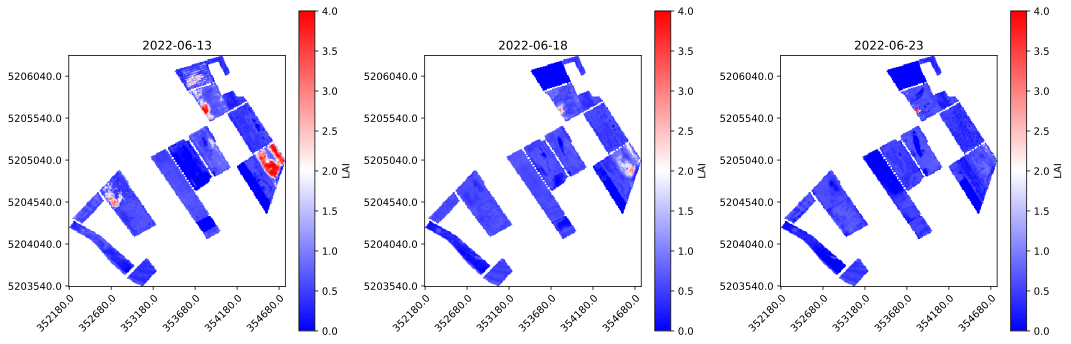

In [92]:
# Plot RGB timeseries

mc_timeseries = diff_preds.sel(time=slice('2022-06-10', '2022-06-30'))

# Plot each RGB image for the first 5 timestamps
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i in range(3):
    im = axs[i].imshow(mc_timeseries[i].values, origin='lower', cmap='bwr', vmin=0, vmax=4)
    axs[i].set_title(f"{str(mc_timeseries.time.values[i]).split('T')[0]}")
    
    # Set extent to match the image dimensions
    axs[i].set_xticks(np.arange(rgb[i].shape[1]))
    axs[i].set_yticks(np.arange(rgb[i].shape[0]))
    
    # Set labels based on the dataset or adjust as needed
    axs[i].set_xticklabels(rgb[i].coords['x'].values)
    axs[i].set_yticklabels(rgb[i].coords['y'].values)
    
    # Customize tick locations and labels
    axs[i].xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    axs[i].yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=6))
    
    # Rotate x-axis labels if needed
    plt.setp(axs[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add colorbar for each subplot
    cbar = fig.colorbar(im, ax=axs[i], orientation='vertical')
    cbar.set_label('LAI')

plt.tight_layout()
plt.show()

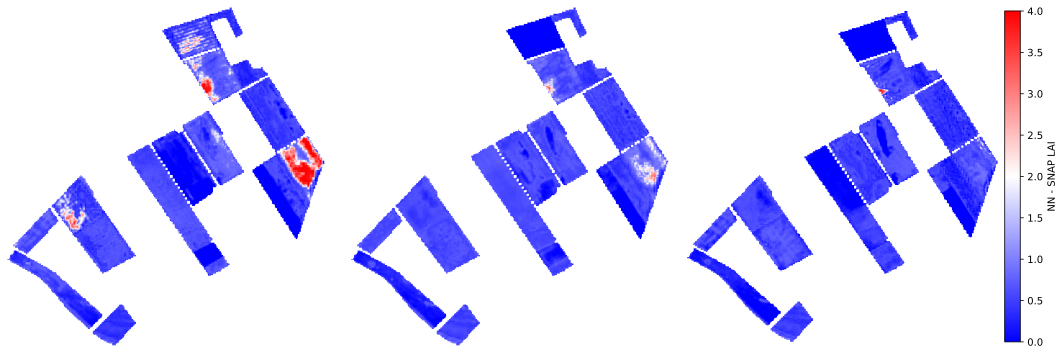

In [97]:
# Without grid or axes

# Select a time slice
mc_timeseries = diff_preds.sel(time=slice('2022-06-10', '2022-06-30'))

# Plot each RGB image for the first 3 timestamps
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    im = axs[i].imshow(mc_timeseries[i].values, origin='lower', cmap='bwr', vmin=0, vmax=4)
    #axs[i].set_title(f"{str(mc_timeseries.time.values[i]).split('T')[0]}")
    
    # Remove axis, ticks, and labels
    axs[i].axis('off')

# Add a single colorbar to the right of the plot
divider = make_axes_locatable(axs[-1])
cax = divider.append_axes("right", size="5%", pad=0.1)

# Use the last image for the colorbar reference
fig.colorbar(im, cax=cax, orientation='vertical').set_label('NN - SNAP LAI')

plt.tight_layout()
plt.savefig('manuscript_figures/diff_timeseries.png')
plt.show()